In [1]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [2]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [3]:
import cvaei
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torch import nn, optim
from cvaei.models.cvae_inference import CVAE
from cvaei.examples.gk_dist import GKDistribution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


In [4]:
gk_dist = GKDistribution()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer, val_theta_norm, val_data_norm = gk_dist.prepare_data(100000)
observed_data = gk_dist.observed_data()
gk_dist.check_normalizer()

Training Theta Shape: torch.Size([100000, 4])
Training Data Shape: torch.Size([100000, 1000])
Validation Theta Shape: torch.Size([10000, 4])
Validation Data Shape: torch.Size([10000, 1000])
Normalization and denormalization process is consistent for both parameters and observed data.


In [5]:
gk_dist.get_info()

theta_normalizer uses device: cpu
data_normalizer uses device: cpu


In [6]:
train_theta_norm.shape, train_data_norm.shape

(torch.Size([100000, 4]), torch.Size([100000, 1000]))

# Initialise the Model

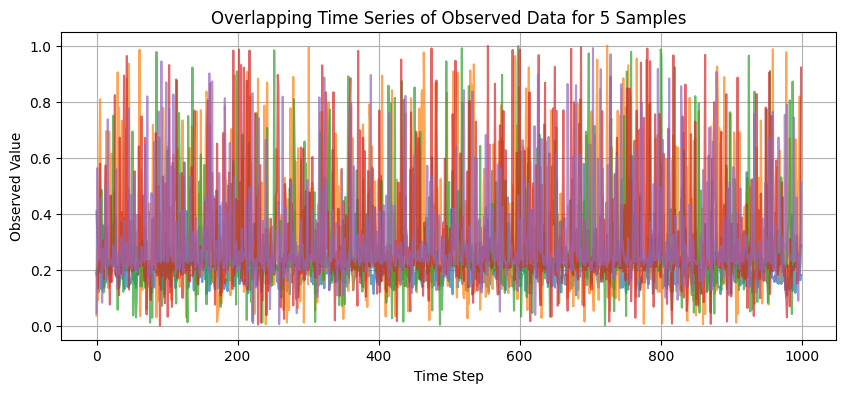

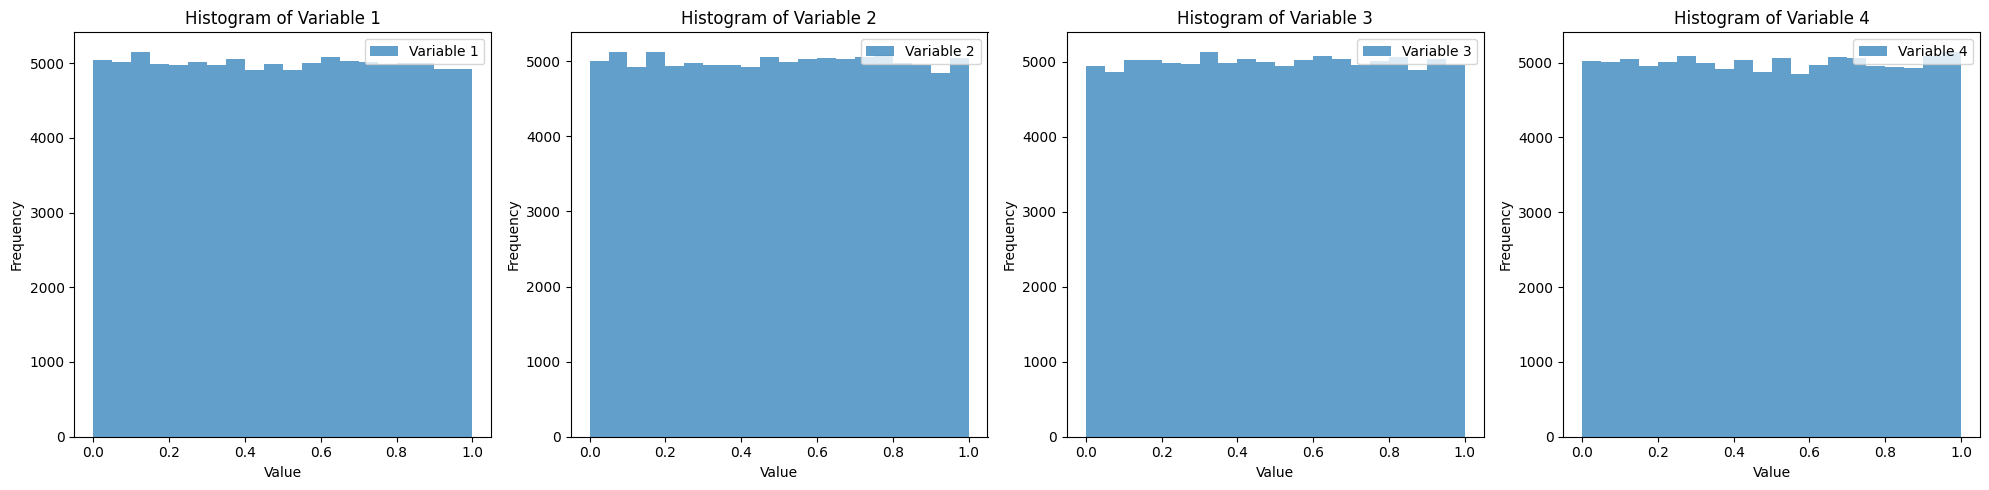

In [7]:
gk_dist.plot_observation(train_data_norm)
gk_dist.plot_prior(train_theta_norm)

# Define the CVAE Network

In [8]:
input_dim = 4
latent_dim = 20
conditional_dim = 1000
encoder_hidden_dims = [100]
decoder_hidden_dims = [2048,2048,2048,2048]
activation_fn = nn.ReLU()

network = CVAE(input_dim=input_dim, 
               latent_dim=latent_dim, 
               output_dim=input_dim,
                conditional_dim=conditional_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                activation_fn = activation_fn)


optimizer = optim.AdamW(network.parameters(), lr=1e-3)


train_dataset = TensorDataset(train_data_norm, train_theta_norm)
val_dataset = TensorDataset(val_data_norm, val_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
validation_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)


train_dataset = TensorDataset(train_data_norm, train_theta_norm)
train_dataset = TensorDataset(train_data_norm, train_theta_norm)

train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)

print(network)

CVAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=100, bias=True)
      (1): ReLU()
    )
    (fc_mean): Linear(in_features=100, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=100, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Linear(in_features=1020, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=2048, bias=True)
      (5): ReLU()
      (6): Linear(in_features=2048, out_features=2048, bias=True)
      (7): ReLU()
    )
    (final_layer): Linear(in_features=2048, out_features=4, bias=True)
  )
)


In [9]:
network.train_model(train_loader=train_loader,
                    validation_loader= validation_loader,
                    optimizer=optimizer,
                    epochs=20, 
                    device=device,
                    theta_normalizer=theta_normalizer,
                    data_normalizer=data_normalizer,
                    forward_model= gk_dist.simulator)

Using CPU for training.
Epoch 1/20: Beta: 0.0, total_loss: 45.0278, recon_loss: 2.2189, misfit_loss: 42.8089, kl_div: 0.4595
Epoch 1/20 Validation: Beta: 0.0, total_loss: 41.6972, recon_loss: 1.6224, misfit_loss: 40.0748, kl_div: 0.7166

Epoch 1: Validation loss improved to 0.0042
Epoch 2/20: Beta: 0.1, total_loss: 41.9504, recon_loss: 1.7423, misfit_loss: 40.1884, kl_div: 0.1964
Epoch 2/20 Validation: Beta: 0.1, total_loss: 41.7547, recon_loss: 1.6870, misfit_loss: 40.0615, kl_div: 0.0616

Epoch 2: No improvement in validation loss for 1 epochs.
Epoch 3/20: Beta: 0.2, total_loss: 41.9554, recon_loss: 1.7948, misfit_loss: 40.1552, kl_div: 0.0269
Epoch 3/20 Validation: Beta: 0.2, total_loss: 41.7336, recon_loss: 1.8671, misfit_loss: 39.8645, kl_div: 0.0096

Epoch 3: No improvement in validation loss for 2 epochs.
Epoch 4/20: Beta: 0.3, total_loss: 41.8378, recon_loss: 1.7105, misfit_loss: 40.1259, kl_div: 0.0048
Epoch 4/20 Validation: Beta: 0.3, total_loss: 41.6329, recon_loss: 1.5971, 

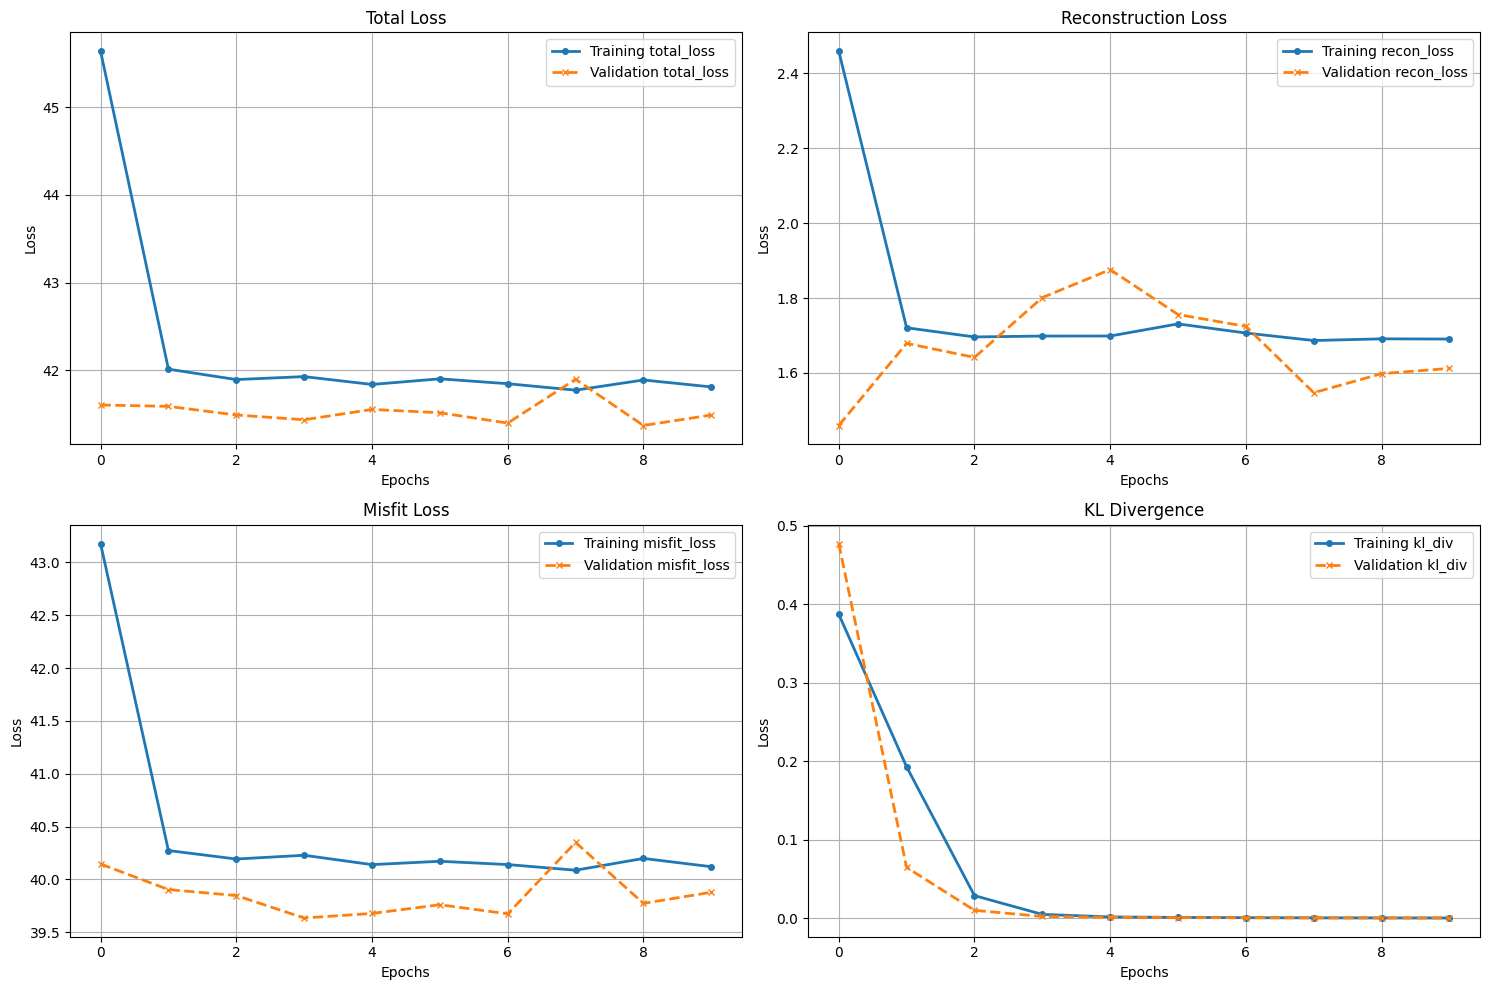

In [ ]:
network.plot_loss()

# Inference

In [ ]:
post = network.get_posterior(observed_data= observed_data, num_samples=1000)
post = theta_normalizer.inverse_transform(post)


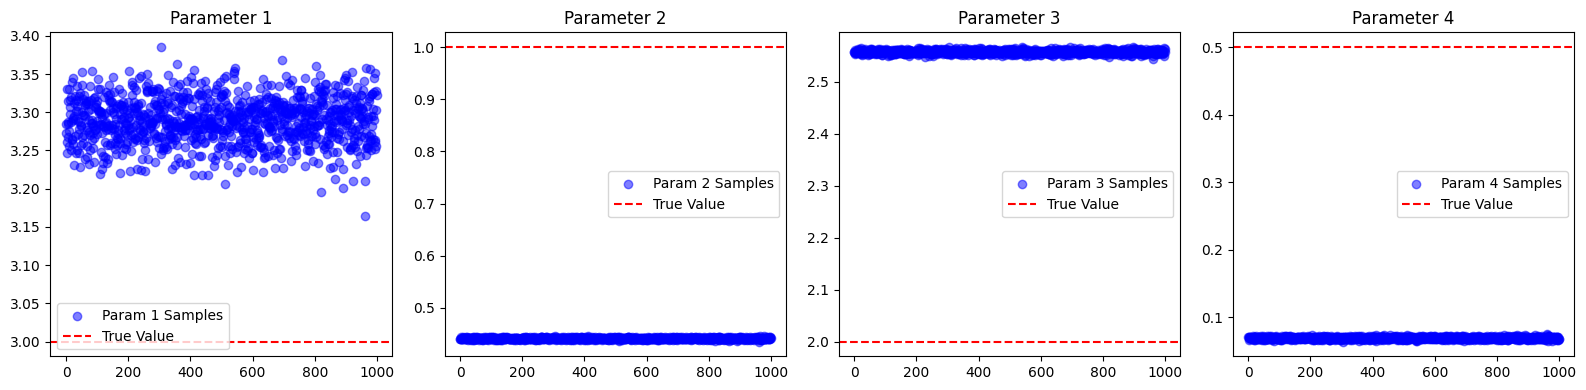

In [ ]:
gk_dist.plot_posterior(post)

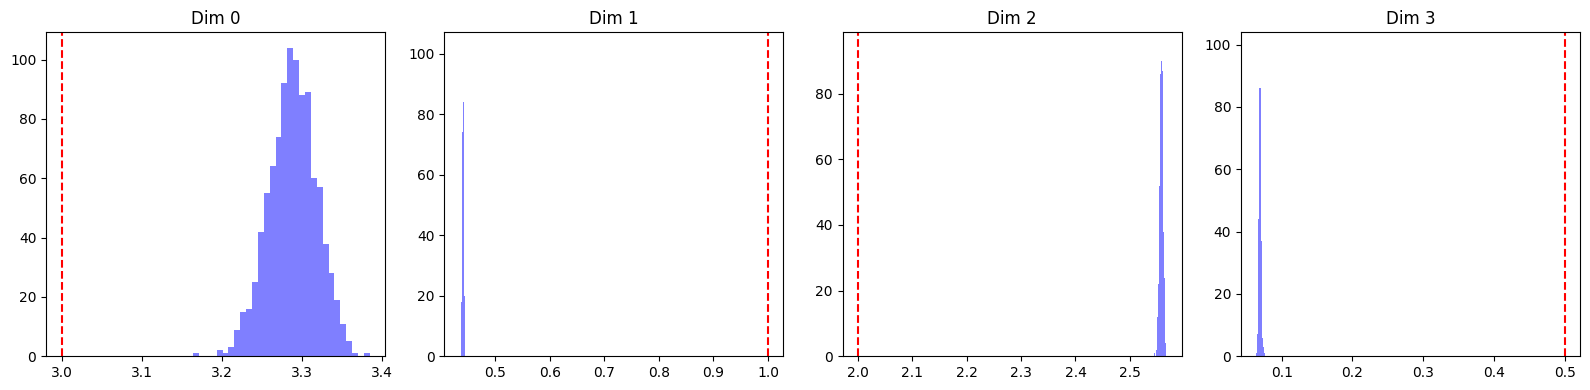

In [ ]:
gk_dist.posterior_hist(post)